In [1]:
import numpy as np
import pywt
import os
from PIL import Image
from scipy.fftpack import dct
from scipy.fftpack import idct

In [2]:
image = 'image.png'
watermark = 'watermark2.png'

In [3]:
def convert_image(image_name, size):
    with open('log/function_calls.txt', 'a') as logfile:
        logfile.write('convert_image\n')
    
    # open image returns image object. resize(required_size_in_tuple), resampling_factor)
    img = Image.open('./pictures/' + image_name).resize((size, size), 1)
    # img.covert('L') returns grayscale image -- 'L' is for grayscale
    img = img.convert('L')
    img.save('./dataset/' + image_name)


    image_array = np.array(img.getdata(), dtype=np.float).reshape((size, size))
#     print(image_array.shape)
#     print(image_array[0][0])
#     print(image_array[10][10])

    return image_array

In [4]:
def process_coefficients(imArray, model, level):
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('process_coefficients\n')
    coeffs=pywt.wavedec2(data = imArray, wavelet = model, level = level)
    # print(coeffs[0].__len__())
    coeffs_H=list(coeffs)

    return coeffs_H

In [5]:
def embed_watermark(watermark_array, orig_image):
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('embed_watermark\n')
    watermark_array_size = watermark_array[0].__len__()
    watermark_flat = watermark_array.ravel()
    ind = 0

    for x in range (0, orig_image.__len__(), 8):
        for y in range (0, orig_image.__len__(), 8):
            if ind < watermark_flat.__len__():
                subdct = orig_image[x:x+8, y:y+8]
                subdct[5][5] = watermark_flat[ind]
                orig_image[x:x+8, y:y+8] = subdct
                ind += 1


    return orig_image

In [6]:
def apply_dct(image_array):
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('apply_dct\n')
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

In [7]:
def inverse_dct(all_subdct):
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('inverse_dct\n')
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct

    return all_subidct

In [8]:
def get_watermark(dct_watermarked_coeff, watermark_size):

    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('get_watermark\n')

    subwatermarks = []

    for x in range (0, dct_watermarked_coeff.__len__(), 8):
        for y in range (0, dct_watermarked_coeff.__len__(), 8):
            coeff_slice = dct_watermarked_coeff[x:x+8, y:y+8]
            subwatermarks.append(coeff_slice[5][5])

    watermark = np.array(subwatermarks).reshape(watermark_size, watermark_size)

    return watermark

In [9]:
def recover_watermark(image_array, model='haar', level = 1):
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('recover_watermark\n')

    coeffs_watermarked_image = process_coefficients(image_array, model, level=level)
    dct_watermarked_coeff = apply_dct(coeffs_watermarked_image[0])

    watermark_array = get_watermark(dct_watermarked_coeff, 128)

    watermark_array =  np.uint8(watermark_array)

#Save result
    img = Image.fromarray(watermark_array)
    img.save('./result/recovered_watermark.jpg')

In [10]:
def print_image_from_array(image_array, name):

    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('print_image_from_array\n')

    image_array_copy = image_array.clip(0, 255)
    image_array_copy = image_array_copy.astype("uint8")
    img = Image.fromarray(image_array_copy)
    img.save('./result/' + name)

In [11]:
import matplotlib.pyplot as plt

def print_dwt_images(coeffs_image):

    ll = coeffs_image[0]
    lh = coeffs_image[1][0]
    hl = coeffs_image[1][1]
    hh = coeffs_image[1][2]
    
#     print(type(coeffs_image[1]), "hdsa", len(coeffs_image[1][0]))
    
    ll_img = Image.fromarray(ll)
    lh_img = Image.fromarray(lh)
    hl_img = Image.fromarray(hl)
    hh_img = Image.fromarray(hh)
    
    
    plt.subplot(2,2,1)
    plt.imshow(ll_img)
    
    plt.subplot(2,2,2)
    plt.imshow(lh_img)
    
    plt.subplot(2,2,3)
    plt.imshow(hl_img)
    
    plt.subplot(2,2,4)
    plt.imshow(hh_img)
    
    plt.show()

In [12]:
def print_dct_image(dct_array):
    
    plt.imshow(dct_array)
    plt.show()

In [19]:
def watermarker():
    with open('./log/function_calls.txt', 'a') as logfile:
        logfile.write('watermarker\n')
    wavelet_type = 'haar'
    level = 1
    image_array = convert_image(image, 2048) # return grayscale of size 2048*2048
    watermark_array = convert_image(watermark, 128) # return grayscale of size 128*128

    coeffs_image = process_coefficients(image_array, wavelet_type, level=level)
    
    print_dwt_images(coeffs_image)
    
    dct_array = apply_dct(coeffs_image[0]) # returns dct of entire image
    dct_array = embed_watermark(watermark_array, dct_array)
    coeffs_image[0] = inverse_dct(dct_array)


# reconstruction
    image_array_H=pywt.waverec2(coeffs_image, wavelet_type)
    print_image_from_array(image_array_H, 'image_with_watermark.jpg')

# recover images
    recover_watermark(image_array = image_array_H, model=wavelet_type, level = level)

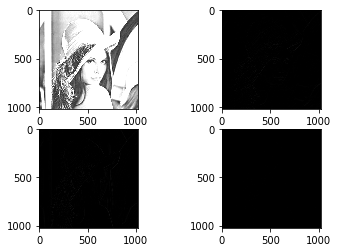

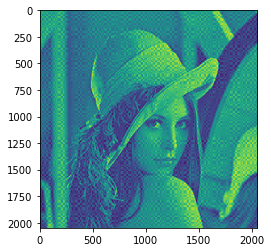

In [18]:
watermarker()